Welcome to the Artifact coding challenge ! We hope you'll have fun and wish you best of luck 😀

Albert and the ear shells
=========================

<img src="https://upload.wikimedia.org/wikipedia/commons/0/0b/AbaloneInside.jpg">

Ear shells are marine snails

The age of ear shells can be determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope - a boring and time-consuming task. 

**Albert**, a scientist and **ear shells** specialist, needs your help. He has collected data on his favorite sea creature and asks you to help him understand it. Then, he would like you to develop a model to predict the number of rings of ear shells (a proxy to their age) using other measurements which are easier to obtain.

# Part 0: Setup

Please include any setup code (including imports) in this section

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from beartype.typing import Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
current_path = os.getcwd()

In [3]:
data_path = os.path.join(current_path, 'earshells.csv')
print(data_path)

/Users/hector/DiaHecDev/pa_recognition/roug_ml/challenge_romero/earshells.csv


# Part 1: Data understanding

## Loading, processing and exploring data

Albert has provided you the dataset `abalone.csv`. Please load it and do what every diligent Data Scientist should do when received a new dataset !

In [4]:
data = pd.read_csv(data_path)
print(len(data))

3174


In [5]:
data.head()

,subset,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings,price
0,train,I,0.349544,0.260194,0.074504,0.179963,0.089707,0.024760,0.054516,5.0,1.205721
1,train,F,0.545249,0.439866,0.134915,0.918132,0.428983,0.201751,0.237840,10.0,18.403463
2,test,F,0.649654,0.544545,0.175080,1.524459,0.590134,0.325970,0.495506,10.0,31.455767
3,train,I,0.500003,0.394566,0.140912,0.621133,0.292336,0.120165,0.195429,9.0,5.647747
4,train,I,0.439268,0.335001,0.110040,0.389429,0.175157,0.083279,0.110899,7.0,1.966989


In [6]:
data.describe()

,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings,price
count,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3143.000000,3143.000000
mean,0.514369,0.400696,0.137644,0.762393,0.342232,0.171397,0.214670,8.688514,12.009276
std,0.134614,0.127081,0.085251,0.467023,0.221347,0.136742,0.134140,1.652502,8.961170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.100000
25%,0.430444,0.330102,0.105422,0.380190,0.164375,0.081057,0.111309,8.000000,4.404896
50%,0.525349,0.409146,0.135162,0.709052,0.311254,0.153026,0.200179,9.000000,10.000912
75%,0.604510,0.474409,0.159900,1.084979,0.489777,0.238163,0.296504,10.000000,18.243623
max,1.973813,3.491197,2.662290,2.987259,1.905003,3.196680,1.545075,11.000000,52.901790


In [7]:
data.sex.unique()

array(['I', 'F', 'M'], dtype=object)

## Questions

Albert needs your help getting a deeper understanding of one particular aspect of this data: the price of ear shells. Can you help him ?

### Question 1.1

What's the **average price** for ear shells with a **diameter** falling outside the interquartile range (of diameter) ?

In [8]:
data_not_nana = data.dropna(subset=['diameter', 'price'])

In [9]:
Q1 = data_not_nana['diameter'].quantile(0.25)
Q3 = data_not_nana['diameter'].quantile(0.75)
IQR = Q3 - Q1
outliers = data_not_nana[(data_not_nana['diameter'] < Q1) | (data_not_nana['diameter'] > Q3)]
average_price_outliers = outliers['price'].mean()

Number of outlier rows: 1572


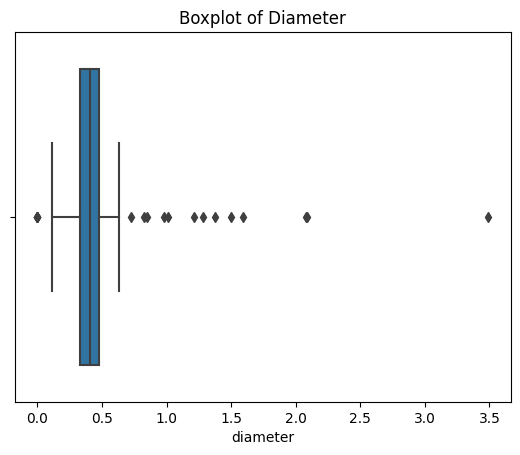

In [10]:
# Check the number of outlier rows:
print("Number of outlier rows:", len(outliers))
sns.boxplot(x=data['diameter'])
plt.title('Boxplot of Diameter')
plt.show()

## R:

In [11]:
print(f"Average price for ear shells with diameter outside the IQR: {average_price_outliers}")

Average price for ear shells with diameter outside the IQR: 13.145458421134752


### Question 1.2

Albert would like to understand which factors / attributes have been used to determine the price. Please provide him with **one clear visualization** which explicits the dependency between the price and the most relevant attributes.

price             1.000000
weight_whole      0.944388
weight_viscera    0.924115
weight_shucked    0.921558
weight_shell      0.913137
diameter          0.864286
length            0.862844
height            0.751823
rings             0.608447
sex              -0.220472
Name: price, dtype: float64


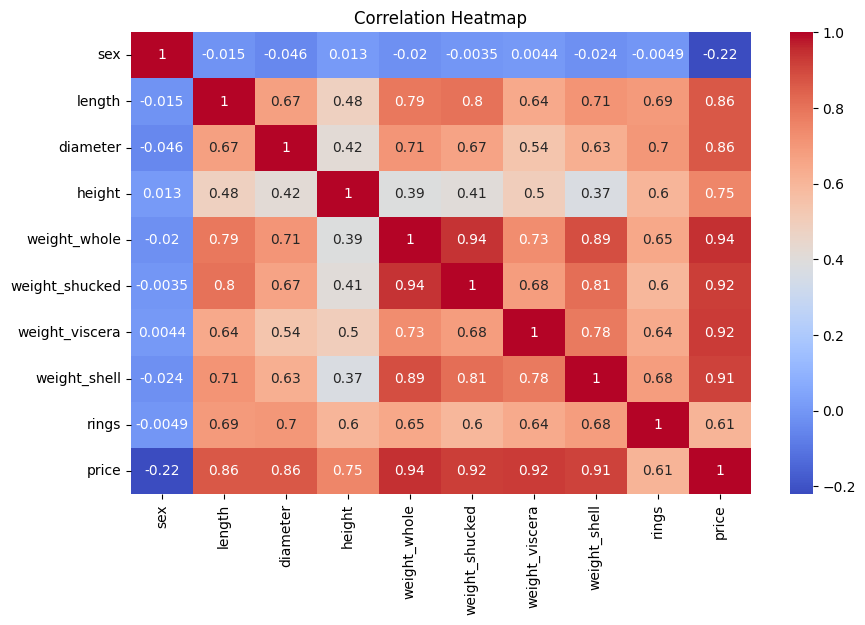

In [76]:
# Using correlation to find dependency
correlations = data.corr()['price'].sort_values(ascending=False)
print(correlations)

# Visualization
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## R: Based on our analysis of the data, the price of ear shells is most closely related to their overall weight. Specifically, the entire weight of the shell, as well as the weights of its individual parts (like the viscera and shucked weight), are the top factors that correlate with the shell's price. The size dimensions of the shell, such as its diameter, length, and height, also influence its price, but not as much as the weight. Lastly, the number of rings, which can give an indication of the age of the shell, has a moderate relation to its price.

# Part 2: Modeling

Albert loves ML ! He asks you to use your ML skills to train a model that will predict the **number of rings** based on the other attributes.

Albert was kind enough to pre-assign the dataset samples to train-test with the `subset` attribute. `test` samples should obviously not be used during the training procedure !

# Question 2.1

Which model will you choose to accomplish this task ? Briefly explain why

## I would choose the RandomForest. This is because it is a versatile algorithm that gives an importance score for each feature, which can be insightful for understanding the model.

## Question 2.2

Which metric would you choose to communicate the performance of your model to Albert ? Briefly explain why

## Accuracy give a good measure of how the algorithm performs (TP, FP, FN, TN)

## Question 2.3

How's your model performing ? Please provide the value of your chosen metric on the **test samples** and briefly discuss it

## R: My model is not performing very well, I would need a little more time to try other approach as feature selection, scaling, and maybe deep learning. 

/Users/hector/tensorflow-metal/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


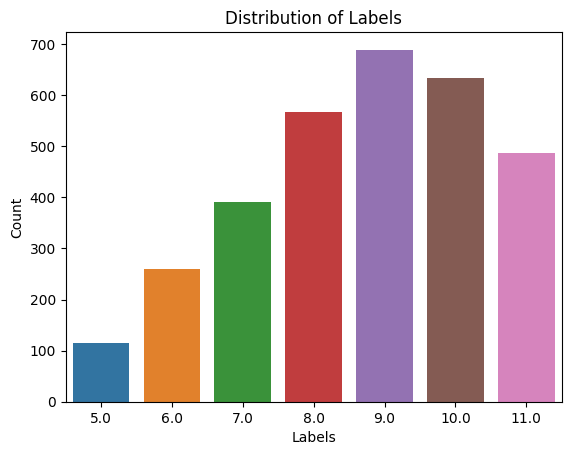

In [106]:
sns.countplot(data['rings'])
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [137]:
# Splitting data into train and test
le = LabelEncoder()
data['sex'] = le.fit_transform(data['sex'])

train_data = data[data['subset'] == 'train'].drop('subset', axis=1)
test_data = data[data['subset'] == 'test'].drop('subset', axis=1)

X_train = train_data.drop(['rings'], axis=1)
y_train = train_data['rings']

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

X_test = test_data.drop(['rings'], axis=1)
y_test = test_data['rings']

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

In [138]:
X_train

,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,price
0,1,0.349544,0.260194,0.074504,0.179963,0.089707,0.024760,0.054516,1.205721
1,0,0.545249,0.439866,0.134915,0.918132,0.428983,0.201751,0.237840,18.403463
3,1,0.500003,0.394566,0.140912,0.621133,0.292336,0.120165,0.195429,5.647747
4,1,0.439268,0.335001,0.110040,0.389429,0.175157,0.083279,0.110899,1.966989
5,1,0.294596,0.220013,0.084899,0.129350,0.058167,0.027437,0.036809,0.229251
...,...,...,...,...,...,...,...,...,...
3168,0,0.645029,0.515352,0.174978,1.545356,0.703173,0.364311,0.415142,30.824711
3169,2,0.690490,0.550416,0.180363,1.692044,0.665989,0.402392,0.500689,25.770539
3170,1,0.345047,0.255339,0.095216,0.194550,0.091683,0.036335,0.055339,2.599017
3172,2,0.749726,0.554736,0.214471,2.200778,1.061781,0.522346,0.527892,32.190442


In [139]:
#scaler = StandardScaler()

# Fit on the training data
#X_train = scaler.fit_transform(X_train)

# Transform the testing data
#X_test = scaler.transform(X_test)

In [140]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [141]:
predictions = model.predict(X_test)
accuracy_score(y_test, predictions)

0.31746031746031744

In [142]:
cm = confusion_matrix(y_test, predictions)


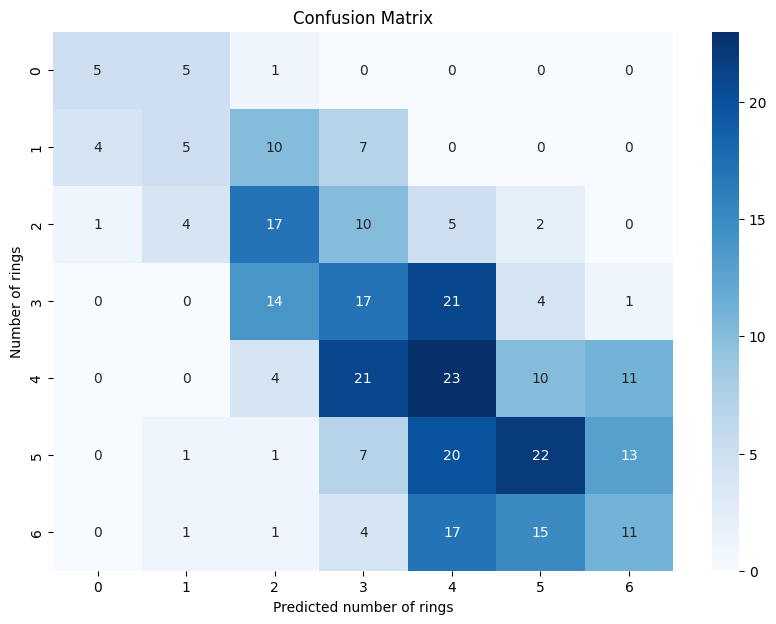

In [143]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted number of rings')
plt.ylabel('Number of rings')
plt.title('Confusion Matrix')
plt.show()

In [144]:
importances = model.feature_importances_

In [145]:
feature_importance = sorted(zip(importances, X_train.columns), reverse=True)

/Users/hector/tensorflow-metal/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


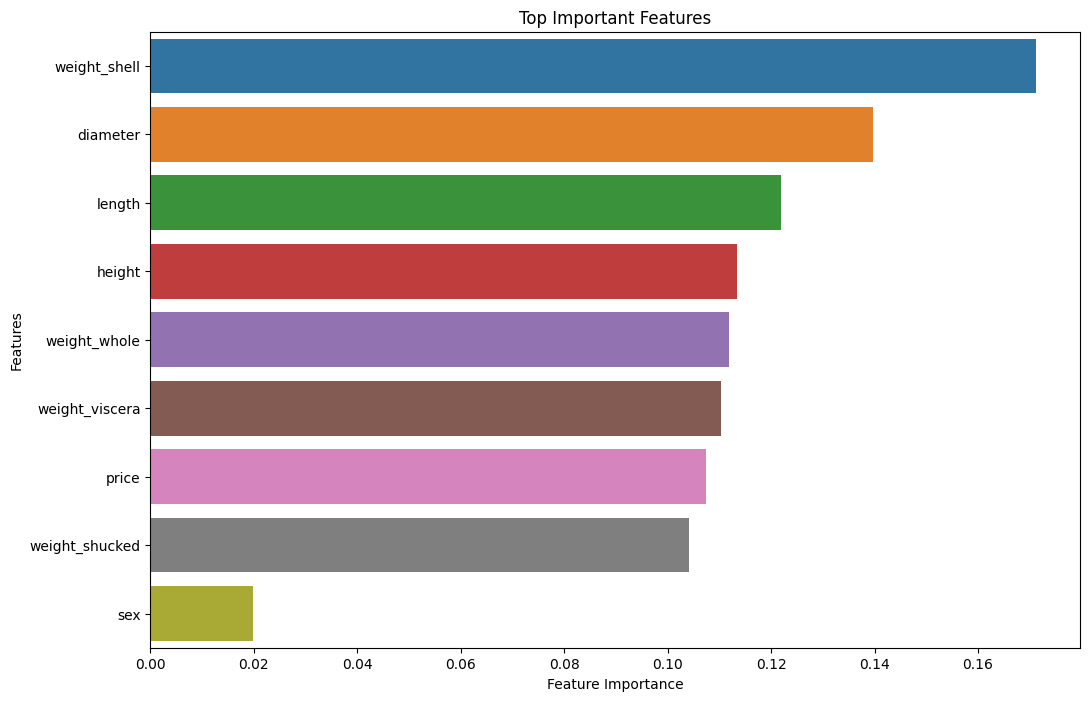

In [146]:
plt.figure(figsize=(12, 8))
sns.barplot([x[0] for x in feature_importance[:]], [x[1] for x in feature_importance[:20]])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Important Features')
plt.show()

In [147]:
accuracy_score(y_test, predictions)

0.31746031746031744

In [148]:
pip freeze | grep -E "numpy|pandas|seaborn|matplotlib|scikit-learn|beartype" > requirements.txt


Note: you may need to restart the kernel to use updated packages.


# The end !

Thank you for participating in this challenge, we hope you enjoyed it !

Don't forget to submit your work by email and to **include a zip of your work** containing:
- your notebook `challenge.ipynb`
- an export of your notebook as HTML `challenge.html`
- a `requirements.txt` file listing your dependencies
- an image of your visualization for question 1.2